# Statistics

In [1]:
import datasets  # Biblioteca de manejo de conjuntos de datos para procesamiento de lenguaje natural
import mt  # Biblioteca del curso donde iremos guardando funciones importantes
import collections  # Módulo de tipos de datos adicionales de Python
import itertools  # Módulo de herramientas de manejo de iterables
import matplotlib.pyplot as plt  # Biblioteca de visualización
import wordcloud  # Biblioteca de visualización de nubes de palabras
import PIL  # Biblioteca de manejo de imágenes
import numpy as np  # Biblioteca de manejo de datos vectoriales
import spacy.lang.es # Biblioteca de procesamiento de lenguaje natural en español

Cargaremos y analizaremos nuestro conjunto de datos y lo compararemos con otro de opiniones de películas.

In [2]:
# Cargamos las particiones de entrenamiento y prueba
spanish_diagnostics = datasets.load_dataset(
    'fvillena/spanish_diagnostics', split="train+test")

In [3]:
spanish_diagnostics

Dataset({
    features: ['text', 'label'],
    num_rows: 100000
})

Esta es una de las instancias de nuestro conjunto de datos.

In [4]:
spanish_diagnostics[2]["text"]

'Perturbación de la actividad y de la atención Trastorno defícit atencional'

Normalizaremos nuestro texto con la función que programamos la clase anterior y tokenizaremos el texto mediante espacio.

In [5]:
spanish_diagnostics_normalized = spanish_diagnostics.map(
    lambda x: {
        "normalized_text": mt.normalize(x["text"])
    })

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [6]:
spanish_diagnostics_normalized_tokenized = spanish_diagnostics_normalized.map(
    lambda x: {
        "tokenized_text": x["normalized_text"].split()
    })

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [7]:
spanish_diagnostics_normalized_tokenized

Dataset({
    features: ['text', 'label', 'normalized_text', 'tokenized_text'],
    num_rows: 100000
})

In [8]:
spanish_diagnostics_normalized_tokenized["tokenized_text"][:3]

[['anomalias',
  'dentofaciales',
  'incluso',
  'la',
  'maloclusion',
  'discrepancia',
  'dentomaxilar'],
 ['obtruccion', 'fosa', 'nasal', 'derecha'],
 ['perturbacion',
  'de',
  'la',
  'actividad',
  'y',
  'de',
  'la',
  'atencion',
  'trastorno',
  'deficit',
  'atencional']]

El conjunto de datos con el cual nos compararemos es un corpus de chistes en español.

In [9]:
# Cargamos el dataset de Muchocine
chistes = datasets.load_dataset('mrm8488/CHISTES_spanish_jokes', split="train")

README.md:   0%|          | 0.00/694 [00:00<?, ?B/s]

(…)-00000-of-00001-b70fa6139e8c3f32.parquet:   0%|          | 0.00/505k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2419 [00:00<?, ? examples/s]

In [10]:
chistes

Dataset({
    features: ['id', 'text', 'keywords', 'funny', 'category'],
    num_rows: 2419
})

In [11]:
chistes_normalized = chistes.map(
    lambda x: {  # Utilizamos una función anónima que devuelve un diccionario
        # Esta es una nueva característica que agregaremos a nuestro conjunto de datos.
        "normalized_text": mt.normalize(x["text"])
    })

Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

In [12]:
chistes_normalized_tokenized = chistes_normalized.map(
    lambda x: {
        "tokenized_text": x["normalized_text"].split()
    })

Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

In [13]:
chistes_normalized_tokenized["tokenized_text"][0][:10]

['rapido',
 'necesitamos',
 'sangre',
 'yo',
 'soy',
 'positivo',
 'pues',
 'muy',
 'mal',
 'necesitamos']

Un *corpus* (plural *corpora*) es el nombre que reciben los conjuntos de datos de texto, estos *corpora* se componen de documentos, los cuales son cada una de las instancias de texto de nuestro *corpus*. Una de las métricas de descripción de *corpora* es el número de documentos, o sea, la cantidad de instancias que tiene mi conjunto de datos.

El número de documentos del *corpus* spanish_diagnostics es mucho mayor al *corpus* muchocine

In [14]:
spanish_diagnostics_n_documents = len(spanish_diagnostics)
spanish_diagnostics_n_documents  # Número de documentos

100000

In [15]:
chistes_n_documents = len(chistes)
chistes_n_documents

2419

A nivel de tokens en nuestro corpus se pueden describir principalmente el número de tokens, el cual es la cantidad total de tokens que presenta nuesto corpus y el tamaño del voculario, el cual es la cantidad de tokens distintos que tiene nuestro corpus.

Utilizaremos la clase collections.Counter para contar las apariciones de cada una de las palabras del vocabulario en los corpora.

In [16]:
spanish_diagnostics_words = collections.Counter(  # Con esta clase contamos cada una de las apariciones de las palabras
    itertools.chain(  # Con esta función aplanamos nuestra lista anidada de tokens
        *spanish_diagnostics_normalized_tokenized["tokenized_text"]
    )
)

In [17]:
chistes_words = collections.Counter(itertools.chain(
    *chistes_normalized_tokenized["tokenized_text"]))

In [18]:
spanish_diagnostics_n_tokens = sum(
    [count for word, count in spanish_diagnostics_words.items()])
spanish_diagnostics_n_tokens

834926

In [19]:
chistes_n_tokens = sum([count for word, count in chistes_words.items()])
chistes_n_tokens

121764

In [20]:
spanish_diagnostics_vocabulary_size = len(spanish_diagnostics_words)
spanish_diagnostics_vocabulary_size

39857

In [21]:
chistes_vocabulary_size = len(chistes_words)
chistes_vocabulary_size

11836

La diversidad léxica es una relación entre el tamaño del vocabulario y la cantidad de tokens. Una diversidad léxica mayor denota una riqueza léxica.

El corpus spanish_diagnostics presenta una diversidad léxica mayor que el corpus muchocine.

In [22]:
spanish_diagnostics_lexical_diversity = spanish_diagnostics_vocabulary_size / \
    spanish_diagnostics_n_tokens
spanish_diagnostics_lexical_diversity

0.04773716473076656

In [23]:
chistes_lexical_diversity = chistes_vocabulary_size / chistes_n_tokens
chistes_lexical_diversity

0.09720442823823133

Exploraremos las palabras ordenadas por frecuencia de aparición. Se sabe que los lenguajes naturales obedecen a la ley de Zipf, la cual define que la frecuencia de cualquier palabra es inversamente proporcional a su posición en una tabla de frecuencias.

Observamos que a medida que vamos avanzando en la posición de frecuencias de las palabras, la frecuencia de cada una cae muy rapidamente.

In [24]:
# Con método collections.Counter.most_common() podemos extraer las palabras más frecuentes del corpus
spanish_diagnostics_words_top_words = spanish_diagnostics_words.most_common(30)

In [25]:
chistes_words_top_words = chistes_words.most_common(30)

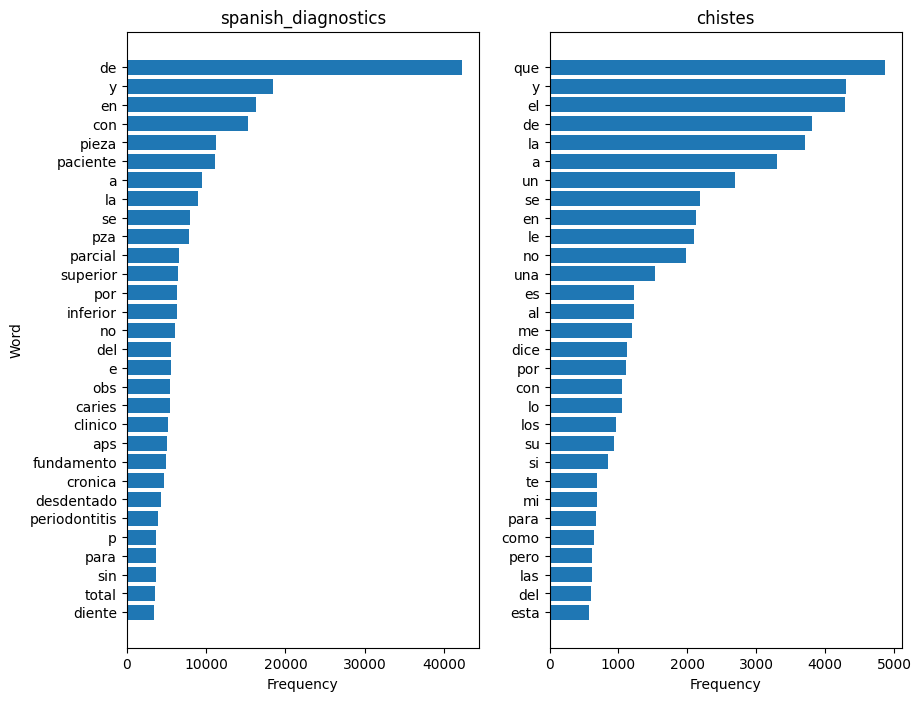

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 8))
axs[0].barh(
    [word for word, f in spanish_diagnostics_words_top_words],
    [f for word, f in spanish_diagnostics_words_top_words],
)
axs[1].barh(
    [word for word, f in chistes_words_top_words],
    [f for word, f in chistes_words_top_words]
)
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[0].set_title("spanish_diagnostics")
axs[1].set_title("chistes")
axs[0].set_ylabel("Word")
axs[0].set_xlabel("Frequency")
axs[1].set_xlabel("Frequency")
plt.show()

Para poder visualizar de mejor manera esta característica podemos visualizar las frecuencias con un gráfico de línea sobre unos ejes en escala logarítmica.

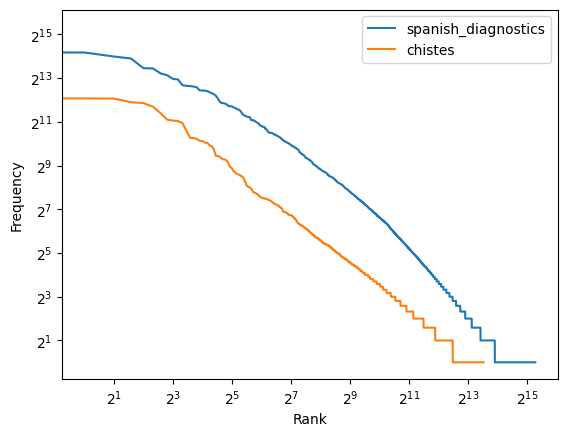

In [27]:
plt.plot([count for word, count in spanish_diagnostics_words.most_common()],
         label="spanish_diagnostics")
plt.plot([count for word, count in chistes_words.most_common()], label="chistes")
plt.yscale("log", base=2)
plt.xscale("log", base=2)
plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.legend()
plt.show()

Una de las visualizaciones de corpora más utilizadas es el Word CLoud, la cual es una representación de la frecuencia (u otra métrica asociada) de las palabras mediante el tamaño de las mismas sobre un lienzo.

Instanciamos un objeto de la clase wordcloud.WordCloud con los parámetros de la visualización.

In [28]:
wc = wordcloud.WordCloud(  # Objeto de WordCloud
    background_color="white",  # El fondo de la visualización es blanco
    colormap="Blues"  # Las palabras tendrán color azul
)

Nos podemos dar cuenta que hay palabras que tienen un tamaño muy grande (o frecuencia muy alta) pero que no nos ayudan a entender el contenido de los corpora. A estas palabras se les denomina stopwords y típicamente se las elimina para poder realizar nuestro análisis.

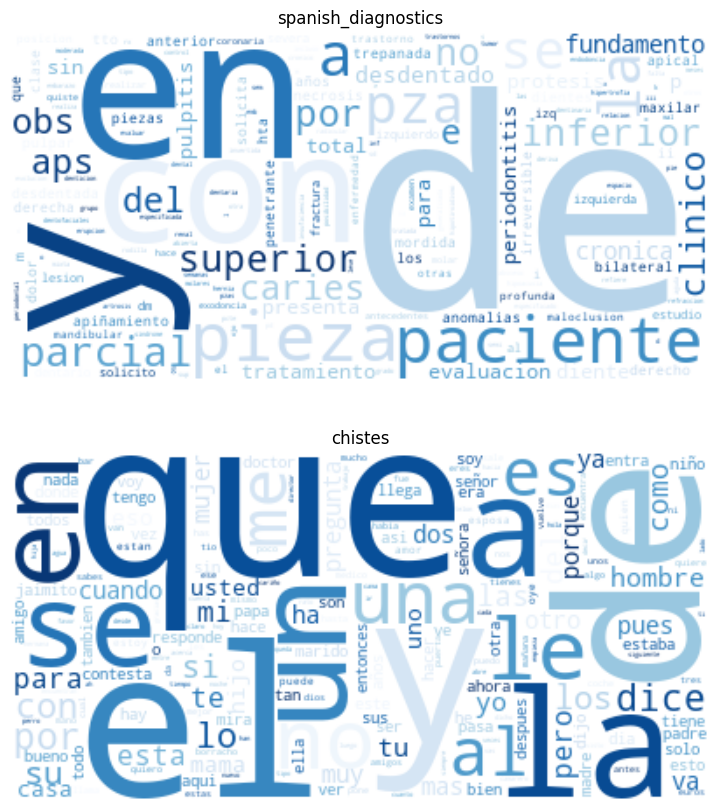

In [29]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 10))
# Creamos el wordcloud desde las frecuencias de las palabras
axs[0].imshow(wc.generate_from_frequencies(
    spanish_diagnostics_words), interpolation="bilinear")
axs[1].imshow(wc.generate_from_frequencies(
    chistes_words), interpolation="bilinear")
axs[0].axis("off")
axs[1].axis("off")
axs[0].set_title("spanish_diagnostics")
axs[1].set_title("chistes")
plt.show()

Existen listas de stopwords típicas en algunas bibliotecas de procesamiento de lenguaje natural.

In [30]:
# La biblioteca Spacy tiene una lista de stopwords en español
stopwords = spacy.lang.es.stop_words.STOP_WORDS

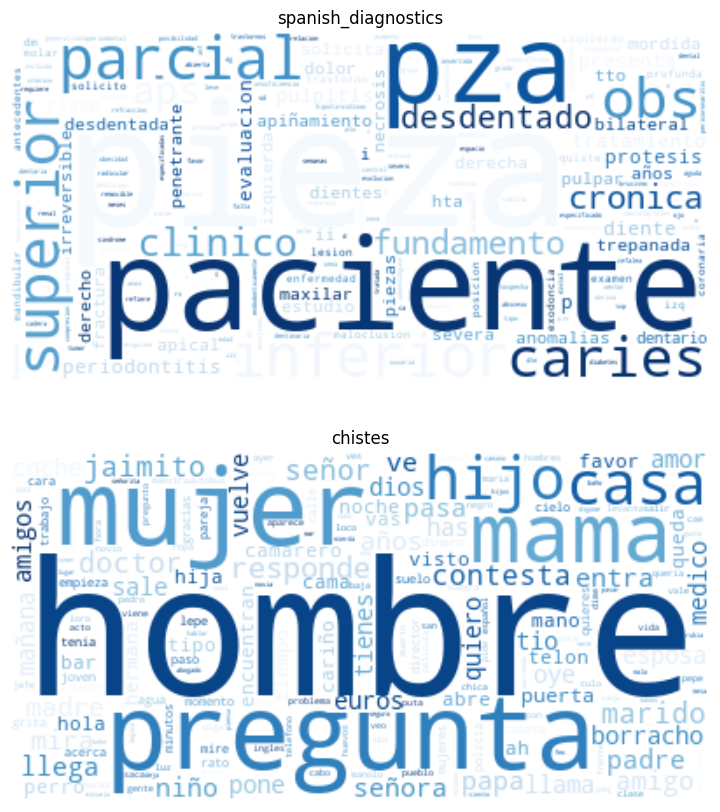

In [31]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 10))
axs[0].imshow(wc.generate_from_frequencies(
    {word: f for word, f in spanish_diagnostics_words.items(
    ) if not word in stopwords}  # Acá eliminamos las stopwords
), interpolation="bilinear")
axs[1].imshow(wc.generate_from_frequencies(
    {word: f for word, f in chistes_words.items() if not word in stopwords}
), interpolation="bilinear")
axs[0].axis("off")
axs[1].axis("off")
axs[0].set_title("spanish_diagnostics")
axs[1].set_title("chistes")
plt.show()

Si bien una lista de stopwords es normalemnte suficiente para limpiar el texto también podemos extender nuestra lista con palabras que nosotros consideremos.

In [32]:
stopwords_extended = list(stopwords) + [  # Agregamos estas palabras que nos están ensuciando la visualización
    "y",
    "a",
    "o"
]

Ahora con nuestros corpora limpios podemos visualizar fácilmente el contenido de nuestros corpora. En el corpus spanish_diagnostics claramente vemos que las palabras más importantes en la visualización son las relacionadas a salud y en el corpus muchocine son palabras relacionadas al cine.

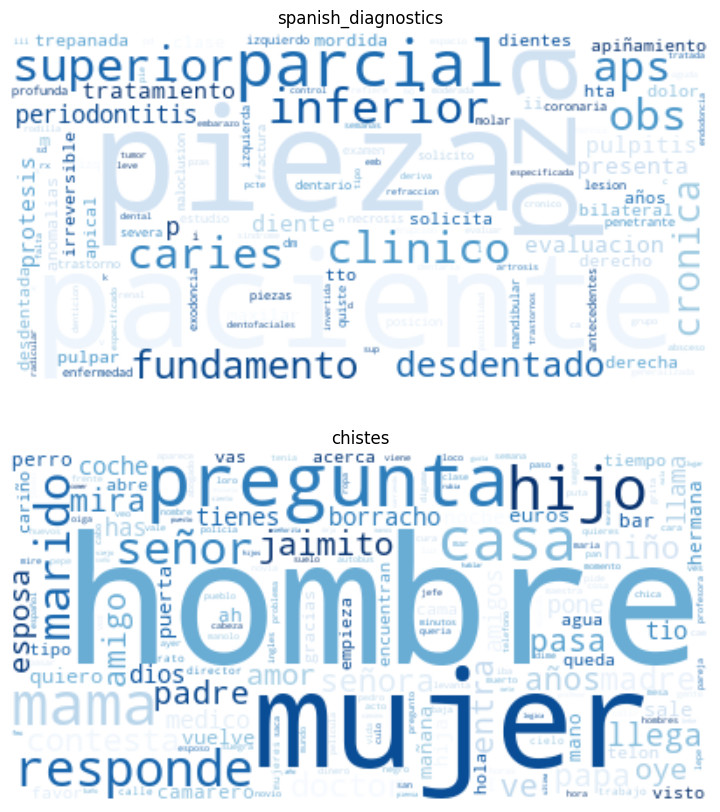

In [33]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 10))
axs[0].imshow(wc.generate_from_frequencies(
    {word: f for word, f in spanish_diagnostics_words.items()
     if not word in stopwords_extended}
), interpolation="bilinear")
axs[1].imshow(wc.generate_from_frequencies(
    {word: f for word, f in chistes_words.items() if not word in stopwords_extended}
), interpolation="bilinear")
axs[0].axis("off")
axs[1].axis("off")
axs[0].set_title("spanish_diagnostics")
axs[1].set_title("chistes")
plt.show()

Para poder enriquecer nuestra visualización podemos agregar máscaras a nuestras nubes y así comunicar mejor la información.

In [34]:
# Importamos las imágenes que utilizaremos como máscaras.
red_cross = np.array(PIL.Image.open("/workspaces/mt/data/red_cross.png"))
play_pause = np.array(PIL.Image.open("/workspaces/mt/data/play_pause.png"))

In [35]:
# Instanciamos un objeto por cada uno de nuestros corpora
wc_spanish_diagnostics = wordcloud.WordCloud(
    background_color="white",
    colormap="Reds",
    mask=red_cross,
    contour_width=3,
    contour_color='red'
)
wc_chistes = wordcloud.WordCloud(
    background_color="white",
    colormap="Blues",
    mask=play_pause,
    contour_width=3,
    contour_color='blue'
)

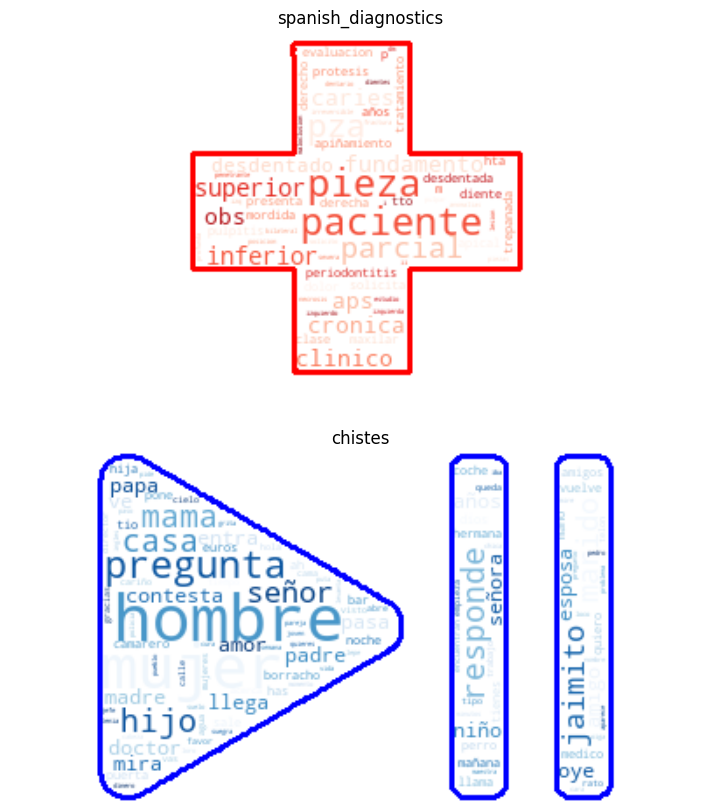

In [36]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 10))
axs[0].imshow(wc_spanish_diagnostics.generate_from_frequencies(
    {word: f for word, f in spanish_diagnostics_words.items()
     if not word in stopwords_extended}
), interpolation="bilinear")
axs[1].imshow(wc_chistes.generate_from_frequencies(
    {word: f for word, f in chistes_words.items() if not word in stopwords_extended}
), interpolation="bilinear")
axs[0].axis("off")
axs[1].axis("off")
axs[0].set_title("spanish_diagnostics")
axs[1].set_title("chistes")
plt.show()